# Load Data

## Load Scores

In [1]:
import pandas as pd

df = pd.read_csv('scores.csv.gz')
df.shape

(21079, 7)

In [2]:
df.head()

,Unnamed: 0,home_team,away_team,game_pk,game_date,post_home_score,post_away_score
0,0,AZ,SF,413660,2015-04-06,4,5
1,1,CIN,PIT,413658,2015-04-06,5,2
2,2,DET,MIN,413656,2015-04-06,4,0
3,3,HOU,CLE,413654,2015-04-06,2,0
4,4,KC,CWS,413653,2015-04-06,10,1


In [3]:
df['home_team_win'] = df.post_home_score > df.post_away_score
df['away_team_win'] = df.post_home_score < df.post_away_score
df['season_year'] = pd.to_datetime(df.game_date).dt.year
scores = df.groupby(['home_team', 'away_team', 'season_year'])[['home_team_win', 'away_team_win']].sum().reset_index()
scores['series_length'] = scores.home_team_win + scores.away_team_win
scores.home_team.unique()

array(['ATL', 'AZ', 'BAL', 'BOS', 'CHC', 'CIN', 'CLE', 'COL', 'CWS',
       'DET', 'HOU', 'KC', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM',
       'NYY', 'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEX',
       'TOR', 'WSH'], dtype=object)

In [4]:
team_mapping = {t: i for i, t in enumerate(df.home_team.unique())}
scores['home_team_id'] = scores.home_team.map(team_mapping)
scores['away_team_id'] = scores.away_team.map(team_mapping)
scores

,home_team,away_team,season_year,home_team_win,away_team_win,series_length,home_team_id,away_team_id
0,ATL,AZ,2015,2,1,3,16,0
1,ATL,AZ,2016,0,3,3,16,0
2,ATL,AZ,2017,3,0,3,16,0
3,ATL,AZ,2018,1,2,3,16,0
4,ATL,AZ,2019,0,3,3,16,0
...,...,...,...,...,...,...,...,...
4915,WSH,TEX,2023,2,1,3,13,22
4916,WSH,TOR,2015,1,2,3,13,29
4917,WSH,TOR,2020,0,2,2,13,29
4918,WSH,TOR,2021,2,0,2,13,29


## Calculate Standings

This just serves as a sanity check that we loaded everything correctly

In [5]:
wins = (
    scores.groupby(['season_year', 'home_team']).home_team_win.sum().rename_axis(['season_year', 'team'])
    + scores.groupby(['season_year', 'away_team']).away_team_win.sum().rename_axis(['season_year', 'team'])
).rename('wins')

losses = (
    scores.groupby(['season_year', 'home_team']).away_team_win.sum().rename_axis(['season_year', 'team'])
    + scores.groupby(['season_year', 'away_team']).home_team_win.sum().rename_axis(['season_year', 'team'])
).rename('losses')

standings = pd.concat([wins, losses], axis=1).sort_index()
standings

wins  losses
season_year team              
2015        ATL     67      95
            AZ      79      83
            BAL     81      81
            BOS     78      84
            CHC     97      65
...                ...     ...
2024        STL     23      26
            TB      25      26
            TEX     24      26
            TOR     22      26
            WSH     21      27

[300 rows x 2 columns]

In [6]:
standings.groupby('season_year').wins.sum() / standings.sum(axis=1).groupby('season_year').sum()

season_year
2015    0.5
2016    0.5
2017    0.5
2018    0.5
2019    0.5
2020    0.5
2021    0.5
2022    0.5
2023    0.5
2024    0.5
dtype: float64

## Load Power Rankings

In [7]:
power_rankings = pd.read_csv('power-rankings.csv').set_index('team')
power_rankings

,Rank,Team,Record,Elo,Opponent Elo,Playoff Odds,Power Score,Δ
team,,,,,,,,
NYY,1,Yankees,33-15,1607,1504,97.6%,1613,3
PHI,2,Phillies,34-14,1598,1471,97.7%,1607,1
LAD,3,Dodgers,32-17,1599,1493,99.4%,1606,-1
ATL,4,Braves,26-16,1589,1504,98.7%,1591,-3
BAL,5,Orioles,29-15,1576,1498,90.8%,1581,0
CLE,6,Guardians,30-17,1546,1486,55.0%,1553,5
KC,7,Royals,29-19,1532,1489,46.9%,1536,3
MIL,8,Brewers,27-19,1527,1502,68.7%,1532,-1
SEA,9,Mariners,25-22,1534,1507,59.0%,1532,0


## Load Schedule

In [8]:
schedule = pd.read_csv('schedule-2024.csv')
schedule['home_team_id'] = schedule.home_team.map(team_mapping)
schedule['away_team_id'] = schedule.away_team.map(team_mapping)
schedule

,date,time,home_team,away_team,home_team_id,away_team_id
0,2024-04-05,6:38 PM,LAA,BOS,21,23
1,2024-04-06,6:38 PM,LAA,BOS,21,23
2,2024-04-07,1:07 PM,LAA,BOS,21,23
3,2024-04-08,6:38 PM,LAA,TB,21,12
4,2024-04-09,6:38 PM,LAA,TB,21,12
...,...,...,...,...,...,...
2423,2024-09-25,7:05 PM,NYY,BAL,8,17
2424,2024-09-26,7:05 PM,NYY,BAL,8,17
2425,2024-09-27,7:05 PM,NYY,PIT,8,26
2426,2024-09-28,1:05 PM,NYY,PIT,8,26


# Define Model

In [9]:
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt


def softmax(a):
    # reshaping for broadcasting
    a = pt.exp(a)
    sum_ = pt.sum(a, axis=1)[None, :].T
    return a / sum_


def Model(home_team_id, away_team_id, N, game_outcomes):
    with pm.Model() as model:
        n_teams = home_team_id.nunique()
        home_team_id = pm.MutableData('home_team_id', home_team_id)
        away_team_id = pm.MutableData('away_team_id', away_team_id)
        N = pm.MutableData('N', N, dims='series')
        
        σ_a_μ = pm.Gamma('σ_a_μ', mu=np.log(5), sigma=np.log(5)/4)
        σ_a_σ = pm.Gamma('σ_a_σ', mu=np.log(5)/4, sigma=np.log(5)/8)
        σ_a = pm.Gamma('σ_a', mu=σ_a_μ, sigma=σ_a_σ)
    
        a_t = pm.Normal('a_t', mu=0, sigma=σ_a, shape=n_teams)
        a_1, a_2 = a_t[home_team_id], a_t[away_team_id]
        a = pt.stack([a_1, a_2]).T
    
        p = pm.Deterministic('p', softmax(a))
        wins = pm.Multinomial(
            'wins',
            n=N,
            p=p,
            observed=game_outcomes,
            dims='series'
        )
    return model

## Fit to 2024

In [10]:
X = scores[scores.season_year.eq(2024)].copy()
X

,home_team,away_team,season_year,home_team_win,away_team_win,series_length,home_team_id,away_team_id
8,ATL,AZ,2024,3,0,3,16,0
18,ATL,BOS,2024,2,0,2,16,23
27,ATL,CHC,2024,2,1,3,16,14
37,ATL,CLE,2024,2,1,3,16,18
73,ATL,MIA,2024,3,0,3,16,6
...,...,...,...,...,...,...,...,...
4830,WSH,LAD,2024,0,3,3,13,5
4849,WSH,MIN,2024,1,2,3,13,24
4873,WSH,PHI,2024,1,2,3,13,10
4882,WSH,PIT,2024,1,2,3,13,26


In [11]:
n_teams = 30
home_team_id = X.home_team_id
away_team_id = X.away_team_id
n_matchups = X.series_length
observed_wins = X[['home_team_win', 'away_team_win']]

model = Model(
    home_team_id=home_team_id,
    away_team_id=away_team_id,
    N=n_matchups,
    game_outcomes=observed_wins
)

### Sample Priors

Sampling: [a_t, wins, σ_a, σ_a_μ, σ_a_σ]


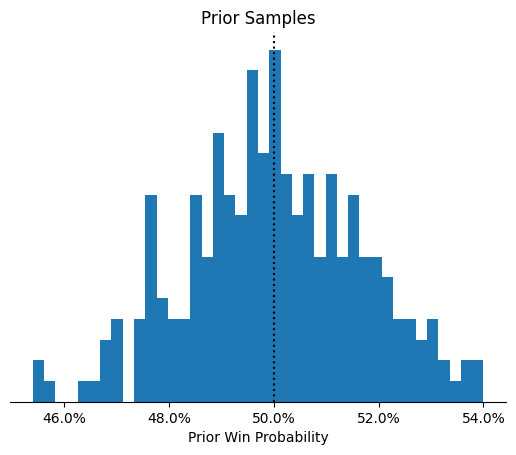

In [12]:
import matplotlib.pyplot as plt

with model:
    priors = pm.sample_prior_predictive()

fig, ax = plt.subplots()
prior_wins = priors.prior_predictive.wins
ax.hist((prior_wins.sum(axis=(0, 1)) / prior_wins.sum(axis=(0, 1, 3)))[:, 0], bins=40)

ax.set_title('Prior Samples')
ax.set_xlabel('Prior Win Probability')
ax.xaxis.set_major_formatter('{x:.1%}')
ax.set_yticks([])
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

ax.axvline(.5, ls=':', color='k')

### Sample Posterior

In [13]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_a_μ, σ_a_σ, σ_a, a_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


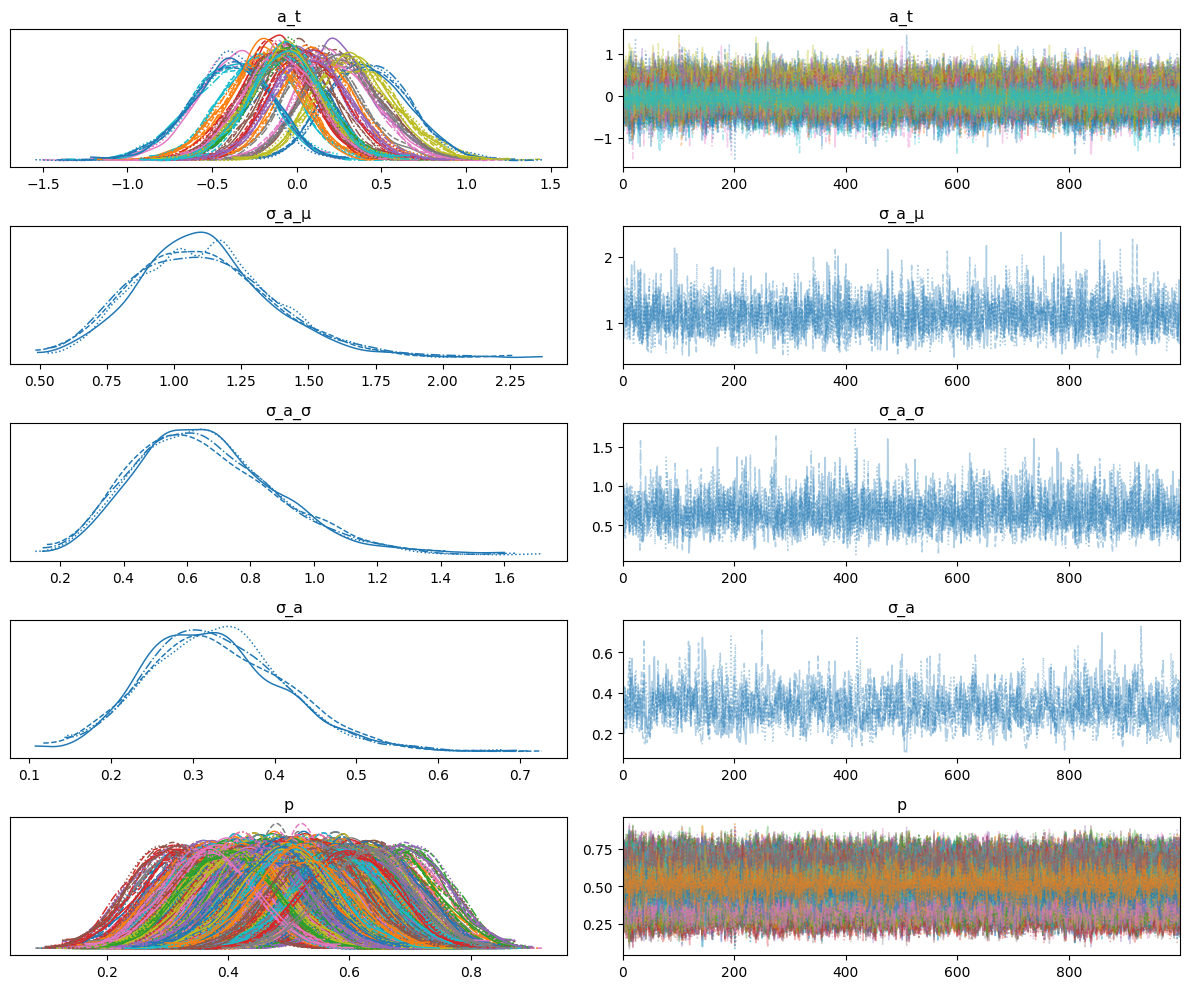

In [14]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(idata)
plt.tight_layout()

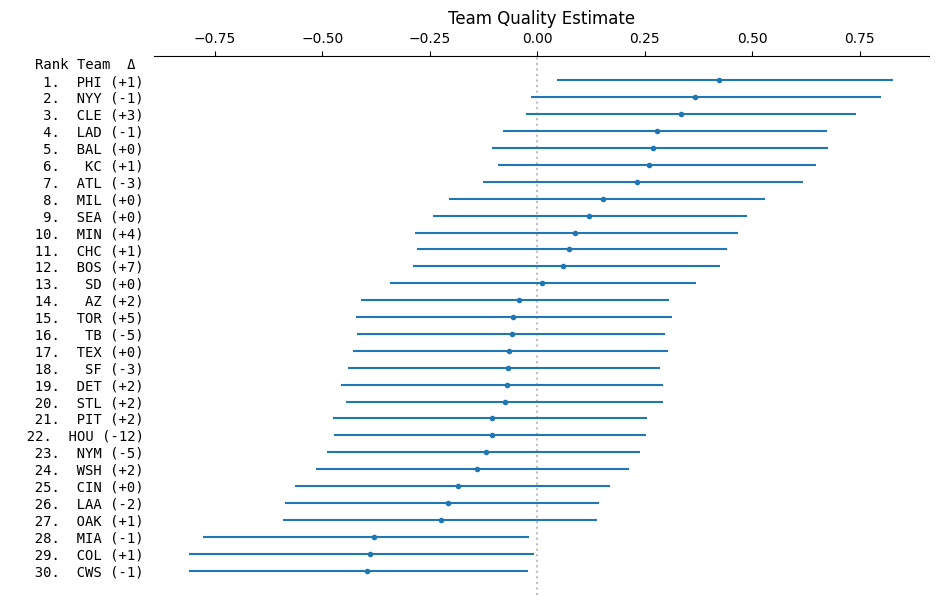

In [15]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 7))

a_t = idata.posterior.a_t.values
μ = a_t.mean(axis=(0, 1))
lower, upper = np.quantile(a_t, [.05, .95], axis=(0, 1))
team_id_lookup = {v: k for k, v in team_mapping.items()}

for i, team_ix in enumerate(np.argsort(μ)[::-1]):
    team = team_id_lookup[i]
    ax.scatter(μ[team_ix], 30-i, color='C0', marker='.')
    ax.hlines(
        30-i,
        lower[team_ix],
        upper[team_ix],
        color='C0'
    )

ax.set_title('Team Quality Estimate')
y_ticklabels = [
    (i+1, team_id_lookup[team_ix], power_rankings.loc[team_id_lookup[team_ix]].Rank)
    for i, team_ix in enumerate(np.argsort(μ)[::-1])
]
ax.set_yticks(
    31-np.arange(31),
    ['Rank Team  Δ '] + [
        f'{rank:>4}. {team:>4} {f"({power_ranking-rank:+})":>4}'
        for rank, team, power_ranking in y_ticklabels
    ],
    fontname='monospace'    
)
plt.tick_params(axis='y', which='both', left=False)
for spine in ['left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
ax.xaxis.tick_top()

ax.axvline(0, color='C7', ls=':', zorder=-1, alpha=.5)

### Forecast Remainder of Schedule

In [16]:
schedule.head()

,date,time,home_team,away_team,home_team_id,away_team_id
0,2024-04-05,6:38 PM,LAA,BOS,21,23
1,2024-04-06,6:38 PM,LAA,BOS,21,23
2,2024-04-07,1:07 PM,LAA,BOS,21,23
3,2024-04-08,6:38 PM,LAA,TB,21,12
4,2024-04-09,6:38 PM,LAA,TB,21,12


In [17]:
# df.game_date.max()
X_forecast = (
    schedule[schedule.date.gt(df.game_date.max())]
    .groupby(['home_team', 'home_team_id', 'away_team', 'away_team_id'])
    .size()
    .rename('n')
    .reset_index()
)
X_forecast

,home_team,home_team_id,away_team,away_team_id,n
0,ATL,16,CIN,1,3
1,ATL,16,COL,19,3
2,ATL,16,DET,2,3
3,ATL,16,KC,4,3
4,ATL,16,LAD,5,4
...,...,...,...,...,...
492,WSH,13,PHI,10,3
493,WSH,13,SD,15,3
494,WSH,13,SEA,11,3
495,WSH,13,SF,27,4


In [18]:
with model:
    pm.set_data(dict(
        home_team_id=X_forecast.home_team_id,
        away_team_id=X_forecast.away_team_id,
        N=X_forecast.n
    ))
    forecast = pm.sample_posterior_predictive(idata, predictions=True)

Sampling: [wins]


In [19]:
forecasted_schedule = pd.concat([
    pd.DataFrame(
        forecast.predictions.wins[..., axis].values.reshape(-1, len(X_forecast)).T,
        index=X_forecast[c].rename('team')
    )
    for c, axis in zip(['home_team', 'away_team'], [0, 1])
])
forecasted_schedule.shape

(994, 4000)

In [20]:
forecasted_wins = forecasted_schedule.groupby('team').sum()
forecasted_wins.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
team,,,,,,,,,,,,,,,,,,,,,
ATL,66,66,68,68,55,81,59,69,63,63,...,60,53,64,49,47,67,59,76,54,71
AZ,53,64,46,61,54,50,49,49,55,59,...,61,47,58,42,58,57,52,60,52,64
BAL,72,56,83,63,63,60,76,56,61,60,...,73,59,51,78,60,62,65,58,69,53
BOS,69,52,68,59,48,46,69,50,62,67,...,52,50,59,62,54,58,57,43,55,52
CHC,76,49,69,69,72,52,65,50,60,54,...,63,58,58,58,54,58,56,65,60,51


In [21]:
forecasted_wins = forecasted_wins.add(standings.loc[2024].wins, axis=0)
forecasted_wins.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
team,,,,,,,,,,,,,,,,,,,,,
ATL,94,94,96,96,83,109,87,97,91,91,...,88,81,92,77,75,95,87,104,82,99
AZ,77,88,70,85,78,74,73,73,79,83,...,85,71,82,66,82,81,76,84,76,88
BAL,101,85,112,92,92,89,105,85,90,89,...,102,88,80,107,89,91,94,87,98,82
BOS,95,78,94,85,74,72,95,76,88,93,...,78,76,85,88,80,84,83,69,81,78
CHC,103,76,96,96,99,79,92,77,87,81,...,90,85,85,85,81,85,83,92,87,78


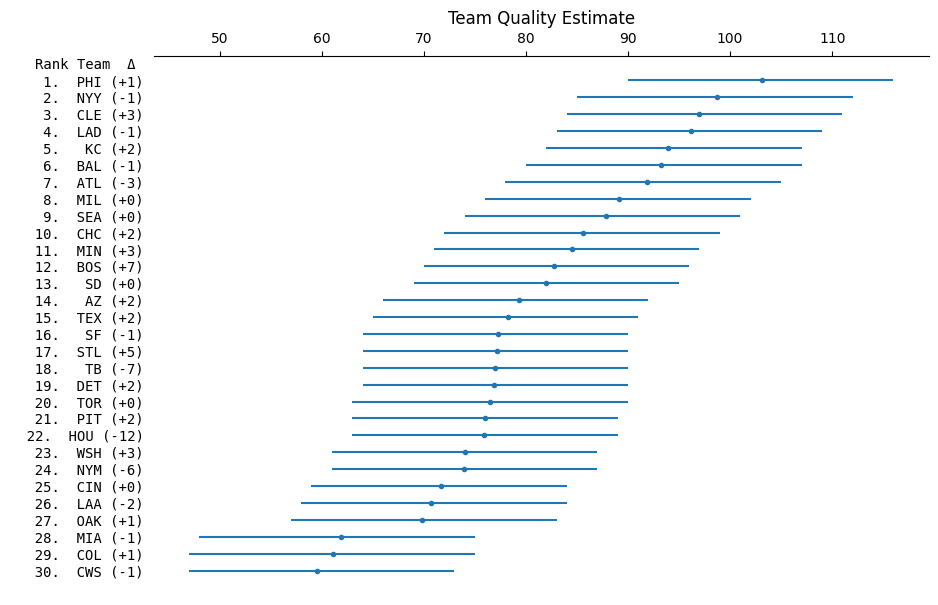

In [22]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 7))

a_t = forecasted_wins
μ = a_t.mean(axis=1)
quantiles = a_t.quantile([.05, .95], axis=1).T
team_id_lookup = {v: k for k, v in team_mapping.items()}

y_ticklabels = []
for i, team in enumerate(μ.sort_values(ascending=False).index):
    # team = team_id_lookup[team]
    ax.scatter(μ[team], 30-i, color='C0', marker='.')
    ax.hlines(
        30-i,
        quantiles.loc[team, .05],
        quantiles.loc[team, .95],
        color='C0'
    )
    y_ticklabels.append((i+1, team, power_rankings.loc[team].Rank))

ax.set_title('Team Quality Estimate')

ax.set_yticks(
    31-np.arange(31),
    ['Rank Team  Δ '] + [
        f'{rank:>4}. {team:>4} {f"({power_ranking-rank:+})":>4}'
        for rank, team, power_ranking in y_ticklabels
    ],
    fontname='monospace'    
)
plt.tick_params(axis='y', which='both', left=False)
for spine in ['left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
ax.xaxis.tick_top()

## Fit to past years

In [23]:
X = scores.copy()
X

,home_team,away_team,season_year,home_team_win,away_team_win,series_length,home_team_id,away_team_id
0,ATL,AZ,2015,2,1,3,16,0
1,ATL,AZ,2016,0,3,3,16,0
2,ATL,AZ,2017,3,0,3,16,0
3,ATL,AZ,2018,1,2,3,16,0
4,ATL,AZ,2019,0,3,3,16,0
...,...,...,...,...,...,...,...,...
4915,WSH,TEX,2023,2,1,3,13,22
4916,WSH,TOR,2015,1,2,3,13,29
4917,WSH,TOR,2020,0,2,2,13,29
4918,WSH,TOR,2021,2,0,2,13,29


In [24]:
home_team_id = (X.season_year - X.season_year.min())*30 + X.home_team_id
away_team_id = (X.season_year - X.season_year.min())*30 + X.away_team_id
n_matchups = X.series_length
observed_wins = X[['home_team_win', 'away_team_win']]

model_all_years = Model(
    home_team_id=home_team_id,
    away_team_id=away_team_id,
    N=n_matchups,
    game_outcomes=observed_wins
)

In [25]:
with model_all_years:
    idata_all_years = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_a_μ, σ_a_σ, σ_a, a_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


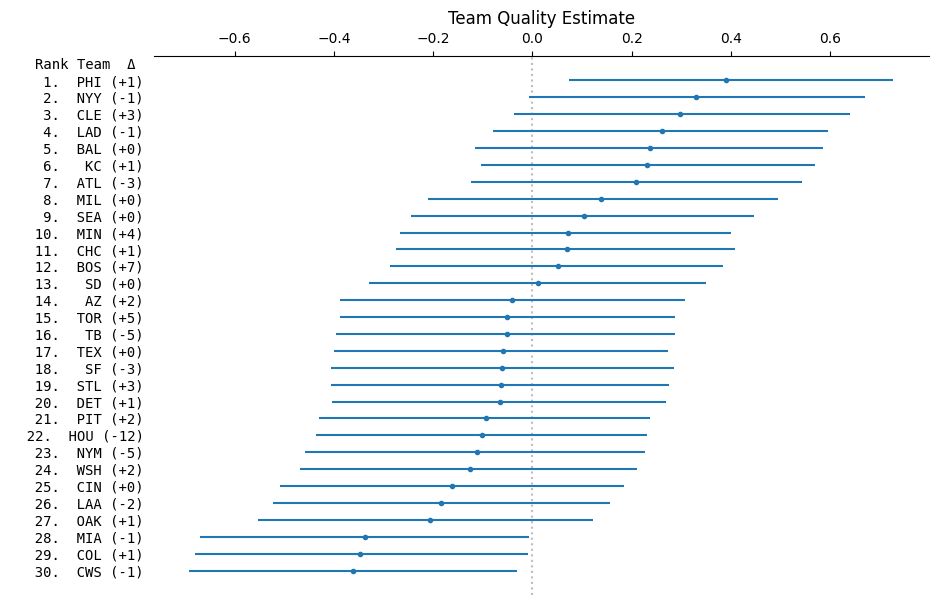

In [26]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 7))

a_t = idata_all_years.posterior.a_t.values[..., 270:]  # TODO: don't hardcode
μ = a_t.mean(axis=(0, 1))
lower, upper = np.quantile(a_t, [.05, .95], axis=(0, 1))
team_id_lookup = {v: k for k, v in team_mapping.items()}

for i, team_ix in enumerate(np.argsort(μ)[::-1]):
    team = team_id_lookup[i]
    ax.scatter(μ[team_ix], 30-i, color='C0', marker='.')
    ax.hlines(
        30-i,
        lower[team_ix],
        upper[team_ix],
        color='C0'
    )

ax.set_title('Team Quality Estimate')
y_ticklabels = [
    (i+1, team_id_lookup[team_ix], power_rankings.loc[team_id_lookup[team_ix]].Rank)
    for i, team_ix in enumerate(np.argsort(μ)[::-1])
]
ax.set_yticks(
    31-np.arange(31),
    ['Rank Team  Δ '] + [
        f'{rank:>4}. {team:>4} {f"({power_ranking-rank:+})":>4}'
        for rank, team, power_ranking in y_ticklabels
    ],
    fontname='monospace'
    
)
plt.tick_params(axis='y', which='both', left=False)
for spine in ['left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
ax.xaxis.tick_top()

ax.axvline(0, color='C7', ls=':', zorder=-1, alpha=.5)

# Compare Latent Posterior Values

(array([  5.,  16.,  32.,  69.,  98., 143., 170., 220., 268., 278., 316.,
        325., 280., 264., 256., 229., 185., 163., 139., 109., 106.,  70.,
         57.,  48.,  42.,  31.,  21.,  12.,   8.,  10.,  10.,   4.,   2.,
          6.,   1.,   5.,   0.,   1.,   0.,   1.]),
 array([0.14896813, 0.19039402, 0.23181992, 0.27324581, 0.3146717 ,
        0.3560976 , 0.39752349, 0.43894938, 0.48037528, 0.52180117,
        0.56322706, 0.60465296, 0.64607885, 0.68750474, 0.72893064,
        0.77035653, 0.81178242, 0.85320832, 0.89463421, 0.9360601 ,
        0.977486  , 1.01891189, 1.06033779, 1.10176368, 1.14318957,
        1.18461547, 1.22604136, 1.26746725, 1.30889315, 1.35031904,
        1.39174493, 1.43317083, 1.47459672, 1.51602261, 1.55744851,
        1.5988744 , 1.64030029, 1.68172619, 1.72315208, 1.76457797,
        1.80600387]),
 <BarContainer object of 40 artists>)

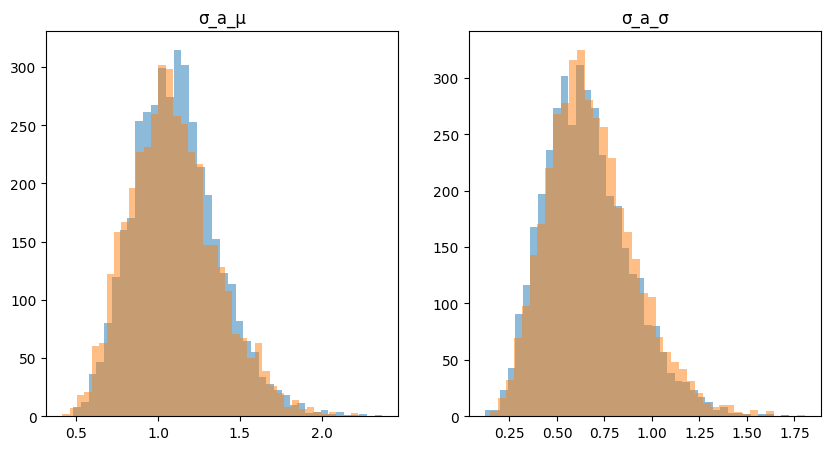

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('σ_a_μ')
axs[0].hist(idata.posterior.σ_a_μ.values.ravel(), bins=40, alpha=.5)
axs[0].hist(idata_all_years.posterior.σ_a_μ.values.ravel(), bins=40, alpha=.5)

axs[1].set_title('σ_a_σ')
axs[1].hist(idata.posterior.σ_a_σ.values.ravel(), bins=40, alpha=.5)
axs[1].hist(idata_all_years.posterior.σ_a_σ.values.ravel(), bins=40, alpha=.5)

# Forecast Remainder of Season

In [28]:
X_forecast = (
    schedule[schedule.date.gt(df.game_date.max())]
    .groupby(['home_team', 'home_team_id', 'away_team', 'away_team_id'])
    .size()
    .rename('n')
    .reset_index()
)
X_forecast

,home_team,home_team_id,away_team,away_team_id,n
0,ATL,16,CIN,1,3
1,ATL,16,COL,19,3
2,ATL,16,DET,2,3
3,ATL,16,KC,4,3
4,ATL,16,LAD,5,4
...,...,...,...,...,...
492,WSH,13,PHI,10,3
493,WSH,13,SD,15,3
494,WSH,13,SEA,11,3
495,WSH,13,SF,27,4


In [29]:
with model_all_years:
    pm.set_data(dict(
        home_team_id=(270+X_forecast.home_team_id),
        away_team_id=(270+X_forecast.away_team_id),
        N=X_forecast.n
    ))
    forecast = pm.sample_posterior_predictive(idata_all_years, predictions=True)

Sampling: [wins]


In [30]:
forecasted_schedule = pd.concat([
    pd.DataFrame(
        forecast.predictions.wins[..., axis].values.reshape(-1, len(X_forecast)).T,
        index=X_forecast[c].rename('team')
    )
    for c, axis in zip(['home_team', 'away_team'], [0, 1])
])
forecasted_schedule.shape

(994, 4000)

In [31]:
forecasted_wins = forecasted_schedule.groupby('team').sum()
forecasted_wins.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
team,,,,,,,,,,,,,,,,,,,,,
ATL,60,62,60,59,66,73,57,55,60,49,...,62,72,61,58,61,60,63,70,66,55
AZ,45,55,60,66,49,50,57,60,51,53,...,69,50,53,42,49,49,66,57,37,62
BAL,44,58,62,60,63,48,63,65,57,68,...,73,56,56,68,70,57,72,52,71,63
BOS,56,49,59,64,51,69,50,59,51,45,...,57,60,62,53,54,63,59,40,48,59
CHC,65,56,65,65,64,45,59,65,57,62,...,51,73,61,48,66,63,60,52,67,63


In [32]:
forecasted_wins = forecasted_wins.add(standings.loc[2024].wins, axis=0)
forecasted_wins.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
team,,,,,,,,,,,,,,,,,,,,,
ATL,88,90,88,87,94,101,85,83,88,77,...,90,100,89,86,89,88,91,98,94,83
AZ,69,79,84,90,73,74,81,84,75,77,...,93,74,77,66,73,73,90,81,61,86
BAL,73,87,91,89,92,77,92,94,86,97,...,102,85,85,97,99,86,101,81,100,92
BOS,82,75,85,90,77,95,76,85,77,71,...,83,86,88,79,80,89,85,66,74,85
CHC,92,83,92,92,91,72,86,92,84,89,...,78,100,88,75,93,90,87,79,94,90


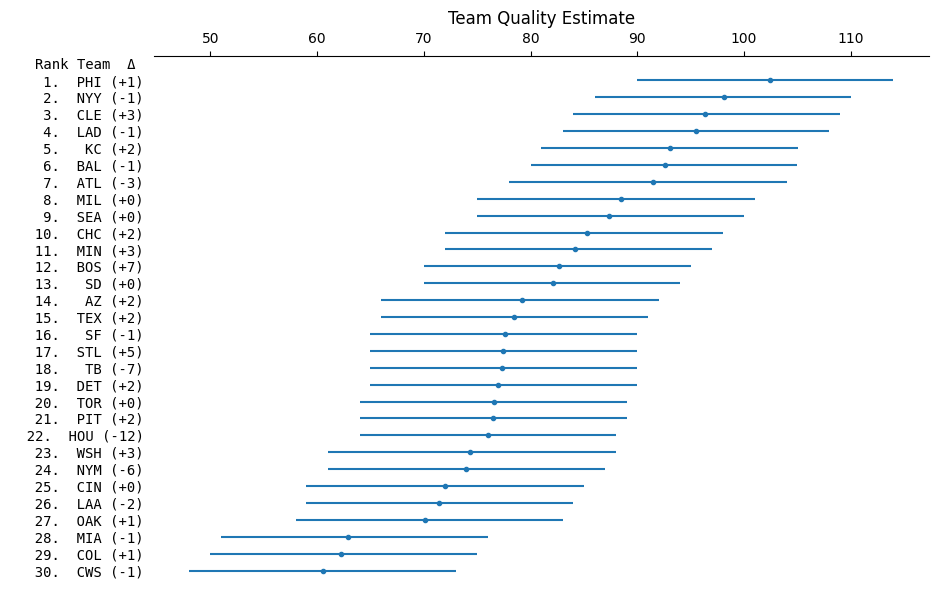

In [33]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 7))

a_t = forecasted_wins
μ = a_t.mean(axis=1)
quantiles = a_t.quantile([.05, .95], axis=1).T
team_id_lookup = {v: k for k, v in team_mapping.items()}

y_ticklabels = []
for i, team in enumerate(μ.sort_values(ascending=False).index):
    # team = team_id_lookup[team]
    ax.scatter(μ[team], 30-i, color='C0', marker='.')
    ax.hlines(
        30-i,
        quantiles.loc[team, .05],
        quantiles.loc[team, .95],
        color='C0'
    )
    y_ticklabels.append((i+1, team, power_rankings.loc[team].Rank))

ax.set_title('Team Quality Estimate')

ax.set_yticks(
    31-np.arange(31),
    ['Rank Team  Δ '] + [
        f'{rank:>4}. {team:>4} {f"({power_ranking-rank:+})":>4}'
        for rank, team, power_ranking in y_ticklabels
    ],
    fontname='monospace'    
)
plt.tick_params(axis='y', which='both', left=False)
for spine in ['left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
ax.xaxis.tick_top()